# Step 0 - Load packages and example data <a id='Step-0'></a>

In [13]:
# R packages
library(raster)
library(data.table)
library(ggplot2)
library(lubridate)

# Source R code and packages used in weather analysis
source('../functions/weatherFunctions.R')
source('../functions/HelperFunctions.R')

# Latitude and longitude of specific site which data will be gathered
lat <- 35.1266
lng <- -111.5854

# Other set up
currMonth <- month(Sys.Date())
Nleads <- 12
n = 30


# Step 1 - Gather point specific historic weather data from gridMet <a id='Step-1'></a>

For a point location (lat, long) historical weather data (01/01/1979 – yesterday) is downloaded from [gridMet](http://www.climatologylab.org/gridmet.html), a daily, high-spatial resolution surface meteorological dataset.

The data repo for gridMet data can be found at https://www.northwestknowledge.net/metdata/data/.

Our function to organize this data is [getWeatherData](../functions/WeatherFunctions.R).

In [14]:
lat <- as.numeric(lat)
lng <- as.numeric(lng)

print(paste('The coordinates are', lat, ",", lng))

#not run wdata <- getWeatherData(lat, lng)
wdata <- fread('../ExampleData/wdata.csv') # historical weather data for the coordinates. 
str(wdata)
summary(wdata)


[1] "The coordinates are 35.1266 , -111.5854"
Classes ‘data.table’ and 'data.frame':	15341 obs. of  6 variables:
 $ Date  : IDate, format: "1979-01-01" "1979-01-02" ...
 $ Year  : int  1979 1979 1979 1979 1979 1979 1979 1979 1979 1979 ...
 $ DOY   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Tmax_C: num  -4.35 3.95 7.85 8.85 7.45 ...
 $ Tmin_C: num  -14.85 -15.85 -6.85 -5.15 -4.95 ...
 $ PPT_cm: num  0 0 0 0 0.18 0.38 0.19 0.22 0.09 0.09 ...
 - attr(*, ".internal.selfref")=<externalptr> 


      Date                 Year           DOY            Tmax_C     
 Min.   :1979-01-01   Min.   :1979   Min.   :  1.0   Min.   :-8.95  
 1st Qu.:1989-07-02   1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.35  
 Median :2000-01-01   Median :2000   Median :183.0   Median :17.95  
 Mean   :2000-01-01   Mean   :2000   Mean   :183.1   Mean   :17.52  
 3rd Qu.:2010-07-02   3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.45  
 Max.   :2020-12-31   Max.   :2020   Max.   :366.0   Max.   :36.75  
     Tmin_C             PPT_cm      
 Min.   :-26.4500   Min.   :0.0000  
 1st Qu.: -5.0500   1st Qu.:0.0000  
 Median :  0.0500   Median :0.0000  
 Mean   :  0.5206   Mean   :0.1392  
 3rd Qu.:  6.7500   3rd Qu.:0.0600  
 Max.   : 17.2500   Max.   :9.2900  

# Step 2 - Gather and format short-term predictions from National Weather Service (NWS) <a id='Step-2'></a>

## Description of data available

The NWS uses "probability of exceedance" curves to give the forecast probability that a temperature or precipitation quantity will be exceeded at the location in question, for the forecast period. 

[temperature probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=t)

[precipitation probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=p)

In addition to the probability of exceedance, a ‘point forecast’ is given for the mean forecasted anomaly and the standard deviation (SD) of that anomaly, as well as percentile (%ile) that this mean will exceed the climatological mean (top left corners of the above figures). These probability of exceedance curves are generated and updated each month for each outlook and region. 

Tabular data for these forecasts are located here:
* [Temperature](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllftd.dat)
* [Precipitation](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllfpd.dat)


## Data access and manipulation

For each set of coordinates, the appropriate region is determined from a shapefile of the [NWS regional map](images/RegionMap.png). The affiliated temperature and precipitation NWS long-lead forecasts data are grabbed from local copies of the tabular data from the NPS. These data are converted into the units we need for our data manipulation (temperature in Celsius, precipitation in centimeters) and anomalies (the difference between the NWS climatological mean and the forecasted mean) are calculated.

In [15]:
# Determine Region from coordinates and shapefile ------------------------------------------
CD102 <- shapefile(x = '../CD102/CD102.shp')
points <- data.frame(x = lng, y = lat)

coordinates(points) <- ~ x + y 
proj4string(points) <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")

CDRegion <- as.numeric(over(points, CD102)$ID4)

# Read in and subset anomaly data -----------------------------------------------------------
TempAnomsWhole <- fread('../CurrentAnomalyTempData.csv') # this data is downloaded from the NWS website
TempAnoms <- subset(TempAnomsWhole, CD == CDRegion)
TempAnoms <- TempAnoms[1:Nleads, ]

PPTAnomsWhole <- fread('../CurrentAnomalyPPTData.csv') # this data is downloaded from the NWS website
PPTAnoms <- subset(PPTAnomsWhole, CD == CDRegion)
PPTAnoms <- PPTAnoms[1:Nleads, ]

# Convert values and calculate NWS anomalies or correction factors -------------------------------------------
  
# Temp
TempAnoms$ClimatologicalMEAN_Temp_C <- (TempAnoms$ClimatologicalMEAN - 32) * (5/9)
TempAnoms$ForecastedMEAN_Temp_C <- (TempAnoms$ForecastedMEAN - 32) * (5/9)
  
TempAnoms$ForecastedSD_Temp_C <- (TempAnoms$ForecastedSD) * (5/9)
TempAnoms$Anom_F <- TempAnoms$ForecastedMEAN - TempAnoms$ClimatologicalMEAN
TempAnoms$Anom_C <- TempAnoms$Anom_F * (5/9)
  
# PPT - keep in transformed units for calcs downstream
## PPT - SDs are given in transformed units. Means are in inches. 
backT <- 1/PPTAnoms$PO

# convert
PPTAnoms$ClimatatologicalMEAN_PPT_PO <- PPTAnoms$ClimatologicalMEAN ^ PPTAnoms$PO
PPTAnoms$ClimatatologicalMEAN_PPT_cm <- PPTAnoms$ClimatologicalMEAN * 2.54
  
PPTAnoms$ForecastedMEAN_PPT_PO <- PPTAnoms$ForecastedMEAN ^ PPTAnoms$PO
PPTAnoms$ForecastedMEAN_PPT_cm <- PPTAnoms$ForecastedMEAN * 2.54
  
PPTAnoms$ForecastedSD_PPT_in <- as.numeric(PPTAnoms$ForecastedSD) ^ backT
PPTAnoms$ForecastedSD_PPT_cm <- PPTAnoms$ForecastedSD_PPT_in * 2.54
  
# calc - anomaly NEEDS to be calcualted in transformed units
PPTAnoms$Anom_PO <- PPTAnoms$ForecastedMEAN_PPT_PO - PPTAnoms$ClimatatologicalMEAN_PPT_PO
PPTAnoms$Anom_cm <- PPTAnoms$ForecastedMEAN_PPT_cm - PPTAnoms$ClimatatologicalMEAN_PPT_cm
PPTAnoms$Anom_CF <- PPTAnoms$ForecastedMEAN / PPTAnoms$ClimatologicalMEAN
  
print('NWS Temperature Data')
TempAnoms
print('NWS Precipitation Data')
PPTAnoms

[1] "NWS Temperature Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,ClimatologicalMEAN_Temp_C,ForecastedMEAN_Temp_C,ForecastedSD_Temp_C,Anom_F,Anom_C
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,10,1,97,37.03,35.83,1.4635,1.64,2.127778,2.794444,0.8130556,1.20,0.6666667
2020,10,2,97,35.38,34.40,1.7474,1.92,1.333333,1.877778,0.9707778,0.98,0.5444444
2020,10,3,97,38.52,37.68,1.6406,1.76,3.155556,3.622222,0.9114444,0.84,0.4666667
2020,10,4,97,43.96,43.17,1.4138,1.56,6.205556,6.644444,0.7854444,0.79,0.4388889
2020,10,5,97,51.55,50.22,1.7180,1.91,10.122222,10.861111,0.9544444,1.33,0.7388889
2020,10,6,97,59.64,58.37,2.0270,2.07,14.650000,15.355556,1.1261111,1.27,0.7055556
2020,10,7,97,67.28,65.99,1.6782,1.68,18.883333,19.600000,0.9323333,1.29,0.7166667
2020,10,8,97,70.78,69.98,1.2777,1.35,21.100000,21.544444,0.7098333,0.80,0.4444444
2020,10,9,97,69.51,68.80,1.0944,1.14,20.444444,20.838889,0.6080000,0.71,0.3944444


[1] "NWS Precipitation Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,PO,ClimatatologicalMEAN_PPT_PO,ClimatatologicalMEAN_PPT_cm,ForecastedMEAN_PPT_PO,ForecastedMEAN_PPT_cm,ForecastedSD_PPT_in,ForecastedSD_PPT_cm,Anom_PO,Anom_cm,Anom_CF
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,10,1,97,3.21,3.30,0.2400,0.24,0.27,1.380380,8.3820,1.370113,8.1534,0.005063911,0.012862334,-0.01026742,-0.2286,0.9727273
2020,10,2,97,3.21,3.42,0.2367,0.24,0.25,1.359899,8.6868,1.338524,8.1534,0.003139012,0.007973092,-0.02137431,-0.5334,0.9385965
2020,10,3,97,3.29,3.68,0.2129,0.23,0.28,1.440248,9.3472,1.395773,8.3566,0.003986827,0.010126540,-0.04447517,-0.9906,0.8940217
2020,10,4,97,2.80,3.27,0.3880,0.40,0.51,1.829866,8.3058,1.690638,7.1120,0.156238369,0.396845458,-0.13922840,-1.1938,0.8562691
2020,10,5,97,2.11,2.49,0.3538,0.36,0.48,1.549443,6.3246,1.431053,5.3594,0.114792138,0.291572029,-0.11839075,-0.9652,0.8473896
2020,10,6,97,1.43,1.43,0.2000,0.20,0.29,1.109296,3.6322,1.109296,3.6322,0.003888290,0.009876256,0.00000000,0.0000,1.0000000
2020,10,7,97,2.76,2.76,0.3600,0.36,0.54,1.730178,7.0104,1.730178,7.0104,0.150777995,0.382976108,0.00000000,0.0000,1.0000000
2020,10,8,97,4.72,4.72,0.3000,0.30,0.49,2.139102,11.9888,2.139102,11.9888,0.085684155,0.217637755,0.00000000,0.0000,1.0000000
2020,10,9,97,5.89,5.89,0.4800,0.48,0.61,2.949649,14.9606,2.949649,14.9606,0.300223478,0.762567633,0.00000000,0.0000,1.0000000


# Step 3 - Use multivariate sampling to generate a range of future anomalies for a specific location  <a id='Step-3'></a>

The NWS future forecasts for each lead are probability curves of potential values for a broad region. We want to create a numerical distribution of potential futures using the NWS data, that also reflects site-specific climatology. To accomplish this, we use multivariate sampling to create 30 different sets of future anomalies, where we consider the differerce between the predicted regional lead and the historical site-specific data (aka the anomaly).

The multivariate sample considers: 
- The covariance between temperature and precipitation anomalies
- NWS lead forecast for the mean anomaly
- NWS lead forecast for the standard deviation 

All precipitation calculations are performed in transformed units.

## Calculation of temperature and precipitation anomalies

For these broad forecasts to reflect site-specific climatology we apply these regional anomalies to site-specific climatological data. To do this we need to create corresponding 'LEAD' periods in the climatological data. To create our sample, we:

1. Calculate monthly mean temperature and the monthly sum of precipitation for each month in a 30 year climatic normal period (1981 - 2010). 
2. Then, using the roll apply function, we mean or sum these monthly values to their affiliated NWS lead (3 month periods). 
3. The difference between the NWS future lead data and historical lead data is calculated, to create an array of meteorological anomalies. 
4. The covariance between these anomaly values is calculated.

We would expect these generated anomaly values to have the same mean, standard deviation, and covariance structure as our dataset. 

Note: Long-lead forecasts are predictions for rolling 3-month long windows. Temperature values (C) are means across 3-month windows and precipitation values (inches) are sums. The LEAD numbering system is relative to the current month. For example, in June, a Lead of 1, refers to the months of June-July-August, Lead 2 refers to July-August-September, and so on and so forth. In order to correctly predict monthly values from the lead data we need to look at what leads are affiliated with each month. To switch between leads and months, we create a monthLeads table.

In [16]:
print("Months & Leads Table")

monthLeads <- makeMonthLeadRelationshipTable(TempAnoms, currMonth)
monthLeads


[1] "Months & Leads Table"


LEAD,Month,lead1,lead2,lead3
<int>,<dbl>,<int>,<dbl>,<dbl>
1,11,1,NA,NA
2,12,2,1,NA
3,1,3,2,1
4,2,4,3,2
5,3,5,4,3
6,4,6,5,4
7,5,7,6,5
8,6,8,7,6
9,7,9,8,7


In [17]:
# Prepare historical data -------------------------------------------------------------------
## Calculate mean daily temperature
wdata$Tmean_C <- rowMeans(wdata[,c('Tmax_C', 'Tmin_C')])

# Determine months
wdata$Month <- month(wdata$Date)
wdata$Date <- NULL

# Aggregate to monthly values
monthlyWdata <- wdata[,.(Tmean_C = mean(Tmean_C), PPT_cm = sum(PPT_cm)), .(Month, Year)]

# Convert monthly PPT to inches 
monthlyWdata$PPT_in <- monthlyWdata$PPT_cm / 2.54

# Aggregate to moving left-aligned 3-month periods (NWS lead seasons)
monthlyWdata$Tmean_C_rollMean <- zoo::rollmean(x = monthlyWdata[,c("Tmean_C")],
                                             k = 3, FUN = mean, fill = NA, 
                                             partial = TRUE, align = "left")
monthlyWdata$PPT_in_rollSum <- zoo::rollsum(x = monthlyWdata[,c("PPT_in")],
                                            k = 3, fill = NA, 
                                            partial = TRUE, align = "left")
# Norm
monthlyWdata <- monthlyWdata[monthlyWdata$Year %in% 1981:2010, ]

# Convert moving left-aligned 3-month periods to NWS leads
monthLeads2 <- monthLeads[1:Nleads,]
monthlyWdata <- merge(monthlyWdata, monthLeads2[,1:2])

# Transform PPT_in_rollingSum using powers (PO) from NWS long-long ppt forecasts
monthlyWdata <- merge(monthlyWdata, PPTAnoms[,c('LEAD', 'PO')], by = 'LEAD')
monthlyWdata$PPT_PO_rollSum <- monthlyWdata$PPT_in_rollSum ^ monthlyWdata$PO


In [18]:
# function to create anomaly data 
generatedAnomData <- generateAnomalyData(monthlyWdata, TempAnoms, PPTAnoms, 
                                         leads = seq_len(Nleads), Nleads = Nleads, 
                                         n = 30)

# to do walk through of this function -------
# print('This is the code for the generateAnomalyData function')
# generateAnomalyData

[1] "Temperature Anomaly by LEAD"
      MVGen_TempAnom_Mean NWS_TempAnom
 [1,]           0.6666667    0.6666667
 [2,]           0.5444444    0.5444444
 [3,]           0.4666667    0.4666667
 [4,]           0.4388889    0.4388889
 [5,]           0.7388889    0.7388889
 [6,]           0.7055556    0.7055556
 [7,]           0.7166667    0.7166667
 [8,]           0.4444444    0.4444444
 [9,]           0.3944444    0.3944444
[10,]           0.4166667    0.4166667
[11,]           0.5055556    0.5055556
[12,]           0.5277778    0.5277778
[1] "Precipitation Anomaly by LEAD"
      MVGen_PPT_CF_Mean NWS_PPT_CF
 [1,]         1.1191452  0.9727273
 [2,]         1.1113727  0.9385965
 [3,]         0.9842438  0.8940217
 [4,]         0.8974449  0.8562691
 [5,]         0.9038887  0.8473896
 [6,]         1.1337836  1.0000000
 [7,]         1.0330017  1.0000000
 [8,]         1.0201868  1.0000000
 [9,]         1.0134964  1.0000000
[10,]         1.0094410  1.0000000
[11,]         1.0581170  1.0000000
[12

Warning message:
“Removed 6 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


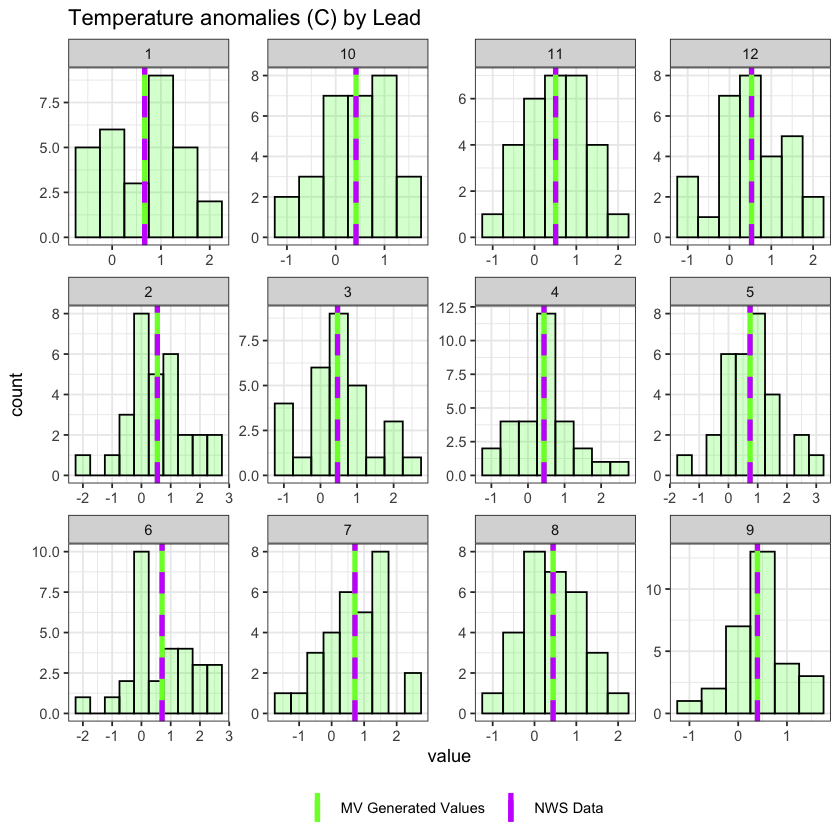

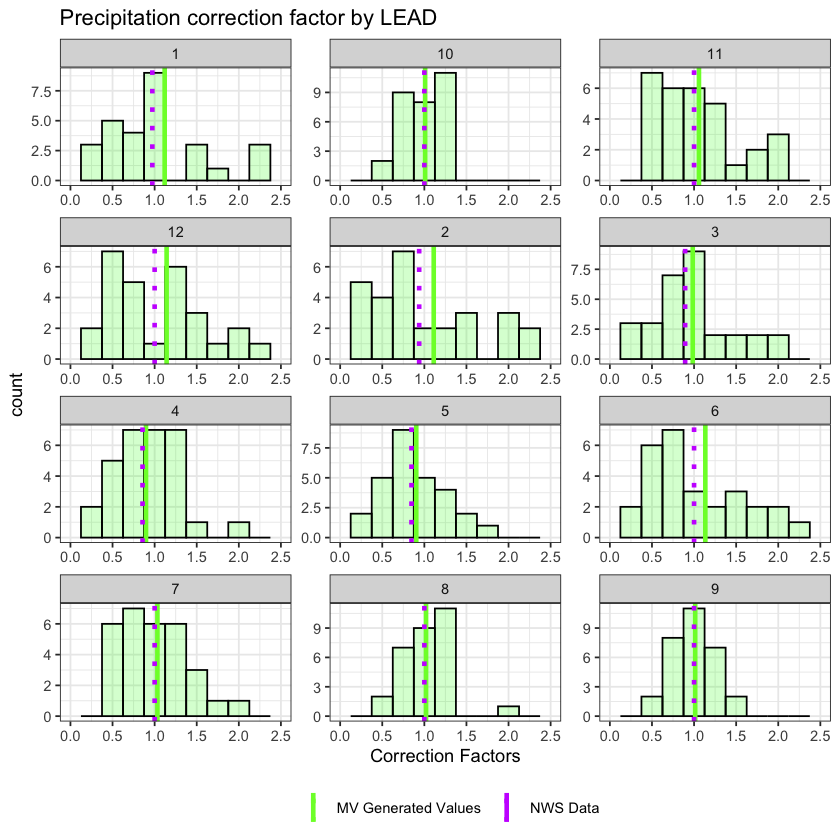

In [7]:
#------ Check generated anomalies against NWS anomalies
# --------- Expection - Mean of predicted multivariate anomalies / correction factors to be very close to the NWS data
# --------- Temperature: Anomaly in C
# --------- Precipitation: Correction Factor (unitless)

# --------- 1: NWS Mean (MAGENTA)
# --------- 2: Multivariate anomalies (GREEN)

print('Temperature Anomaly by LEAD')
source('../figureCode/testFigs/LEADS/TempbyLeads.R')

print('Precipitation Anomaly by LEAD')
source('../figureCode/testFigs/LEADS/PPTbyLeads_CorrectionFactor.R')


# Step 4 - Bias correction of anomaly forecasts<a id='step4'></a>

We apply a bias correction factor to the multivariate anomaly predictions. 

Any draw of multivariate anomalies might result in an overprediction or underprection of values. This is especially evident for the precipitation anomaly correction factor, where the transformation of our anom prediction (predicted in transformed units) from a normal distribution curve, to one that is right-skewed (in centimeters) and then converted to a correction factor leads to 'drifting' from the NWS corrrection factor values.

This is evident in the PPT figure below (Note: This a static figure).

![image](images/SamplingExplorePPT.png)

![image](images/SamplingExploreTemp.png)


This bias correction is calculated by:
* PPT CF - dividing the mean of the multivariate sampled distribution lead correction factor by the NWS correction factor
* Temp Anom -  taking the differenve between the multivariate anomaly mean and the NWS anomaly mean.

This bias correction is then applied to the entire distribution per lead.

In [19]:
# Step 2.1 - Correction factor to the correction factor based on mean -------------------------------

### Temperature
tempGenAnoms <- data.table(generatedAnomData [, , "dT_C"])
tempGenAnoms$LEAD <- row.names(tempGenAnoms)
tempGenAnoms <- melt(tempGenAnoms, id.vars = 'LEAD')
tempGenAnoms <- tempGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]

TempBiasCF <- TempAnoms$Anom_C - tempGenAnoms$MVGenMean 

print('Temperature Anomaly Bias Correction Factors per Lead')
print(cbind(NWSAnomMean  = TempAnoms$Anom_C , MVAnomMEan = tempGenAnoms$MVGenMean,  TempBiasCF))

generatedAnomData [, , "dT_C"] <- generatedAnomData [, , "dT_C"] + TempBiasCF

### Precipitation
pptGenAnoms <- data.table(generatedAnomData [, , "PPT_CF"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(MVGenMean = mean(value)),.(LEAD)]

PPTBiasCF <- PPTAnoms$Anom_CF / pptGenAnomsMean$MVGenMean 

print('Precipitation Anomaly Bias Correction Factors per Lead')
print(cbind(NWSAnomMean  = PPTAnoms$Anom_CF, MVAnomMean = pptGenAnomsMean$MVGenMean,  PPTBiasCF))

generatedAnomData [, , "PPT_CF"] <- generatedAnomData [, , "PPT_CF"] * PPTBiasCF

##### ------ Recalculate PPT_GenForecasted_cm
## ----- need for figures but not used anywhere in analysis
generatedAnomData[, , 'PPT_GenForecasted_cm'] <-
generatedAnomData [, , "PPT_CF"] * PPTAnoms$ClimatatologicalMEAN_PPT_cm
  

[1] "Temperature Anomaly Bias Correction Factors per Lead"
      NWSAnomMean MVAnomMEan    TempBiasCF
 [1,]   0.6666667  0.6666667  0.000000e+00
 [2,]   0.5444444  0.5444444  0.000000e+00
 [3,]   0.4666667  0.4666667 -1.110223e-16
 [4,]   0.4388889  0.4388889  5.551115e-17
 [5,]   0.7388889  0.7388889  1.110223e-16
 [6,]   0.7055556  0.7055556  0.000000e+00
 [7,]   0.7166667  0.7166667  0.000000e+00
 [8,]   0.4444444  0.4444444  5.551115e-17
 [9,]   0.3944444  0.3944444 -1.110223e-16
[10,]   0.4166667  0.4166667  5.551115e-17
[11,]   0.5055556  0.5055556  0.000000e+00
[12,]   0.5277778  0.5277778  0.000000e+00
[1] "Precipitation Anomaly Bias Correction Factors per Lead"
      NWSAnomMean MVAnomMean PPTBiasCF
 [1,]   0.9727273  1.1229701 0.8662094
 [2,]   0.9385965  1.1085616 0.8466796
 [3,]   0.8940217  0.9870206 0.9057782
 [4,]   0.8562691  0.8973461 0.9542239
 [5,]   0.8473896  0.9036373 0.9377541
 [6,]   1.0000000  1.1260340 0.8880726
 [7,]   1.0000000  1.0332021 0.9678648
 [8,]   1

[1] "Temperature Anomaly by LEAD"
      MVGen_TempAnom_Mean NWS_TempAnom
 [1,]           0.6666667    0.6666667
 [2,]           0.5444444    0.5444444
 [3,]           0.4666667    0.4666667
 [4,]           0.4388889    0.4388889
 [5,]           0.7388889    0.7388889
 [6,]           0.7055556    0.7055556
 [7,]           0.7166667    0.7166667
 [8,]           0.4444444    0.4444444
 [9,]           0.3944444    0.3944444
[10,]           0.4166667    0.4166667
[11,]           0.5055556    0.5055556
[12,]           0.5277778    0.5277778
[1] "Precipitation Anomaly by LEAD"
      MVGen_PPT_CF_Mean NWS_PPT_CF
 [1,]         0.9727273  0.9727273
 [2,]         0.9385965  0.9385965
 [3,]         0.8940217  0.8940217
 [4,]         0.8562691  0.8562691
 [5,]         0.8473896  0.8473896
 [6,]         1.0000000  1.0000000
 [7,]         1.0000000  1.0000000
 [8,]         1.0000000  1.0000000
 [9,]         1.0000000  1.0000000
[10,]         1.0000000  1.0000000
[11,]         1.0000000  1.0000000
[12

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


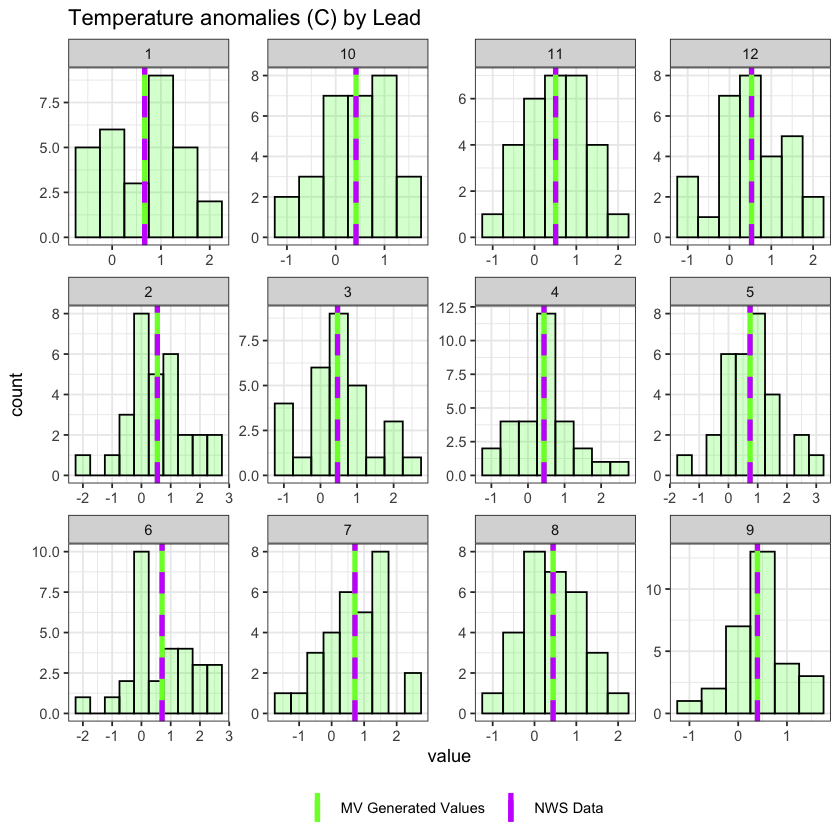

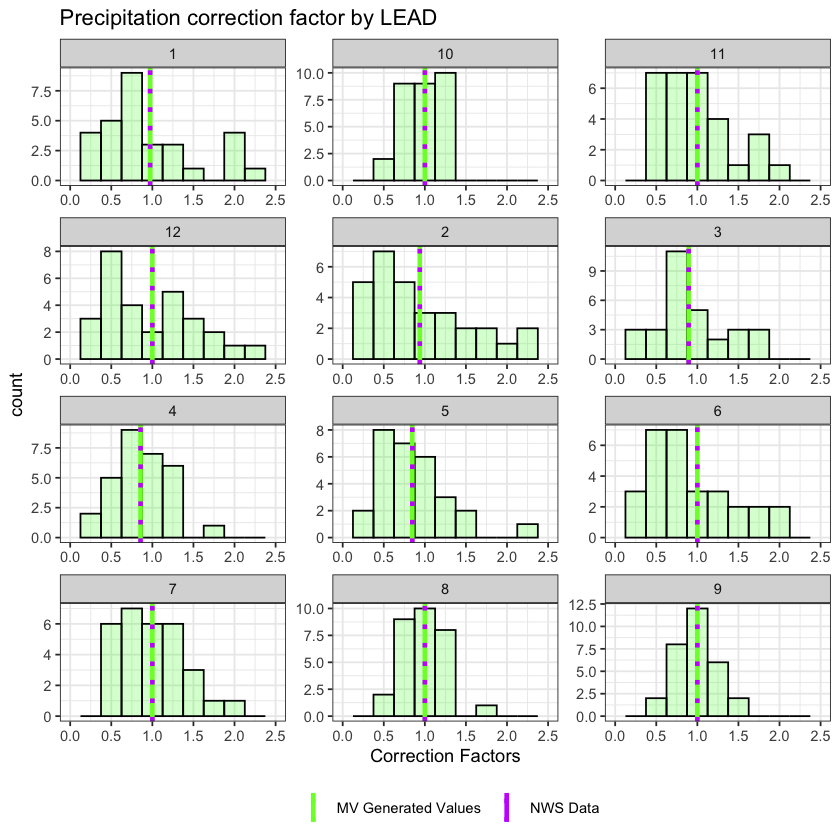

In [9]:
#------ Check generated anomalies against NWS anomalies
# --------- Expection - Mean of predicted multivariate anomalies to be the same as NWS data

# --------- 1: NWS Mean (MAGENTA)
# --------- 1: Random Univariate sample for comparison (ORANGE)
# --------- 2: Multivariate anomalies (GREEN)

print('Temperature Anomaly by LEAD')
source('../figureCode/testFigs/LEADS/TempbyLeads.R')

print('Precipitation Anomaly by LEAD')
source('../figureCode/testFigs/LEADS/PPTbyLeads_CorrectionFactor.R')

# Step 5 - Integrate future anomalies with historical data to create future weather dataset <a id='Step-5'></a>

Next, the anomalies generated for each lead must be transformed into monthly values so we can apply the anomalies to the historical data. Using the monthLeads table we loop through each month and find the affiliated leads. Values are then averaged across leads for monthly temperature anomaly and precipiation correction factor.

Finally, these monthly anomalies are then added (temp) or multipled (ppt) to each day in the relative month across the historical series, to generate future daily data for a 30 year period.


In [20]:
# Get monthly averages across leads --------------------------------------------------
MonthlyAnoms <- data.frame()
for(nn in 1:n){
    
    # Get monthly averages across leads --------------------------------------------------
    OneYearAnom <- generatedAnomData[ , nn, ]
    OneYearAnom  <- cbind(OneYearAnom, Climatological_MEAN_cm = PPTAnoms$ClimatatologicalMEAN_PPT_cm[1:12])
    OneYearAnom <- cbind(OneYearAnom, Anom_cm = OneYearAnom[,4] - OneYearAnom[,6])
    
    yearlydat <- data.frame(matrix(nrow = 12, ncol = 3))
    names(yearlydat) <- c('tempAnom', 'pptAnom_cm', 'pptAnom_CF')
    yearlydat$Month <- as.numeric(row.names(yearlydat))
    
    for(m in c(yearlydat$Month)){ # for each month, m, in a year, nn
    
      mLeads <- c(t(monthLeads[monthLeads$Month == m, 3:5]))

      #temp
      yearlydat[m, 1] <- mean(OneYearAnom[mLeads, 'dT_C'], na.rm = TRUE) 
      
      # ppt cm
      yearlydat[m, 2] <-  mean(OneYearAnom[mLeads, 'Anom_cm'], na.rm = TRUE)/3
      
      # ppt correction factor
      yearlydat[m, 3] <-  mean(OneYearAnom[mLeads, 'PPT_CF'], na.rm = TRUE)

    }
        MonthlyAnoms <- rbind(MonthlyAnoms, yearlydat)
  }
  


print('summary of weather data before anomalies')
summary(wdata)

### Find month in wdata and merge anomalies
wdata$Month <-  month(as.Date(strptime(paste(wdata$Year, wdata$DOY), format="%Y %j"), format="%m-%d-%Y"))
wdata <- merge(wdata, yearlydat)

### Temp ------------------------------------------------------------------------------------ 
wdata$Tmax_C <- wdata$Tmax_C + wdata$tempAnom
wdata$Tmin_C <- wdata$Tmin_C + wdata$tempAnom

### Precip ----------------------------------------------------------------------------
wdata$PPT_cm <- wdata$PPT_cm * wdata$pptAnom_CF

# That's it
wdata <- wdata[,c('Year', 'DOY', 'Tmax_C', 'Tmin_C', 'PPT_cm')]
print('summary of weather data after anomalies')
summary(wdata)

[1] "summary of weather data before anomalies"


      Year           DOY            Tmax_C          Tmin_C        
 Min.   :1979   Min.   :  1.0   Min.   :-8.95   Min.   :-26.4500  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.35   1st Qu.: -5.0500  
 Median :2000   Median :183.0   Median :17.95   Median :  0.0500  
 Mean   :2000   Mean   :183.1   Mean   :17.52   Mean   :  0.5206  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.45   3rd Qu.:  6.7500  
 Max.   :2020   Max.   :366.0   Max.   :36.75   Max.   : 17.2500  
     PPT_cm          Tmean_C           Month       
 Min.   :0.0000   Min.   :-17.50   Min.   : 1.000  
 1st Qu.:0.0000   1st Qu.:  2.65   1st Qu.: 4.000  
 Median :0.0000   Median :  8.85   Median : 7.000  
 Mean   :0.1392   Mean   :  9.02   Mean   : 6.523  
 3rd Qu.:0.0600   3rd Qu.: 16.25   3rd Qu.:10.000  
 Max.   :9.2900   Max.   : 25.40   Max.   :12.000  

[1] "summary of weather data after anomalies"


      Year           DOY            Tmax_C           Tmin_C        
 Min.   :1979   Min.   :  1.0   Min.   :-9.795   Min.   :-27.3945  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.505   1st Qu.: -4.9406  
 Median :2000   Median :183.0   Median :18.437   Median :  0.5164  
 Mean   :2000   Mean   :183.1   Mean   :18.044   Mean   :  1.0450  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:26.187   3rd Qu.:  7.7103  
 Max.   :2020   Max.   :366.0   Max.   :38.563   Max.   : 19.0634  
     PPT_cm        
 Min.   : 0.00000  
 1st Qu.: 0.00000  
 Median : 0.00000  
 Mean   : 0.18390  
 3rd Qu.: 0.07315  
 Max.   :16.95542  

### Check  generated monthly anom data vs. NWS data (NWS lead data averaged to correct month)

[1] "Density plots of monthly anomalies used in SOILWAT2 vs NWS"


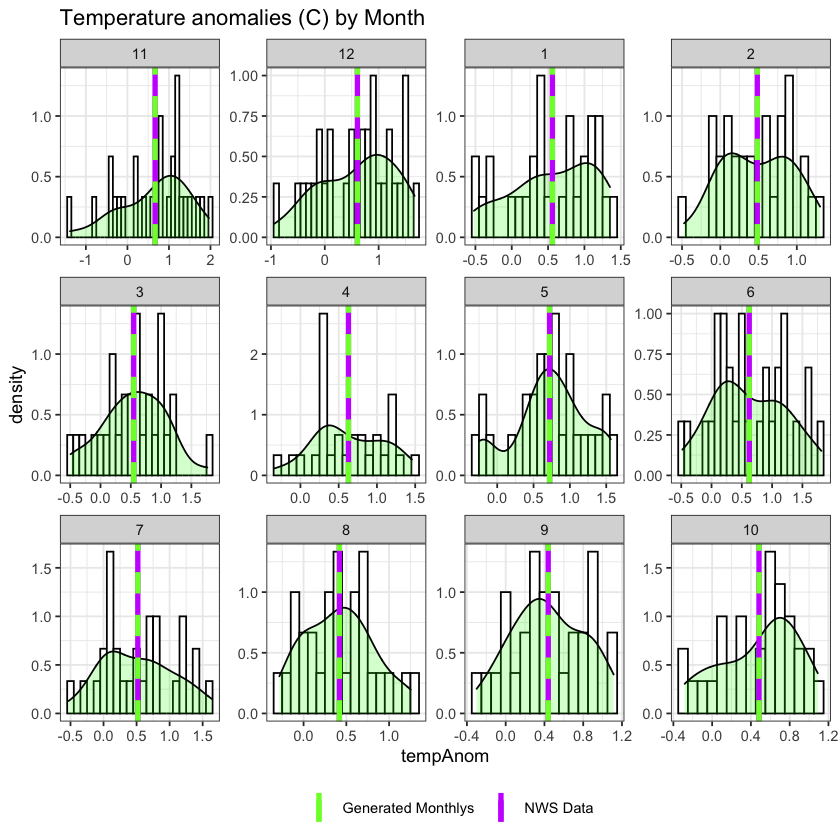

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



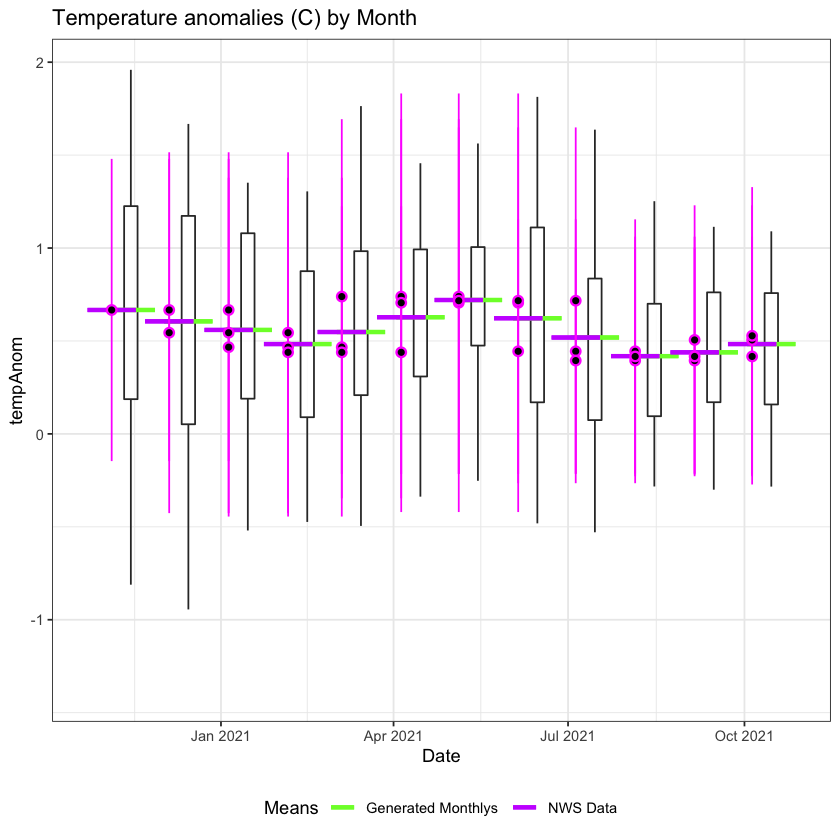

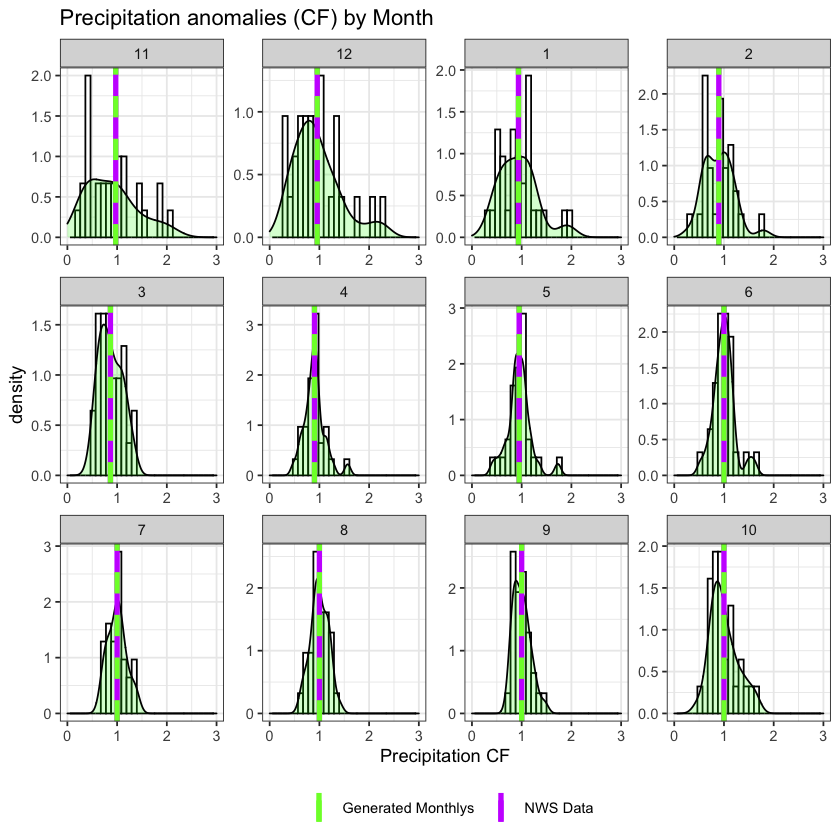

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



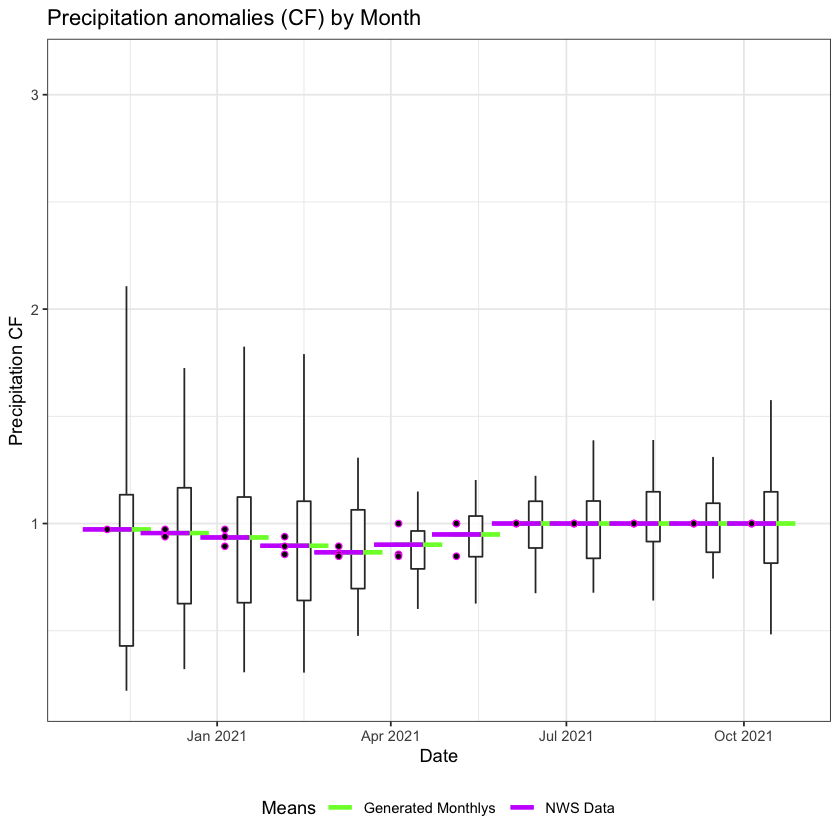

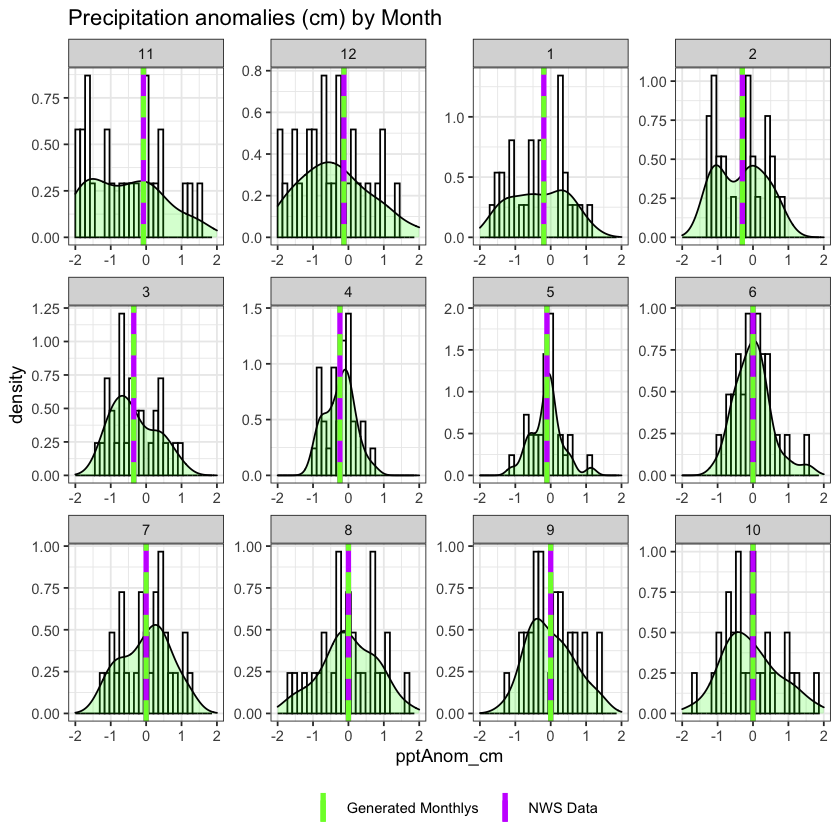

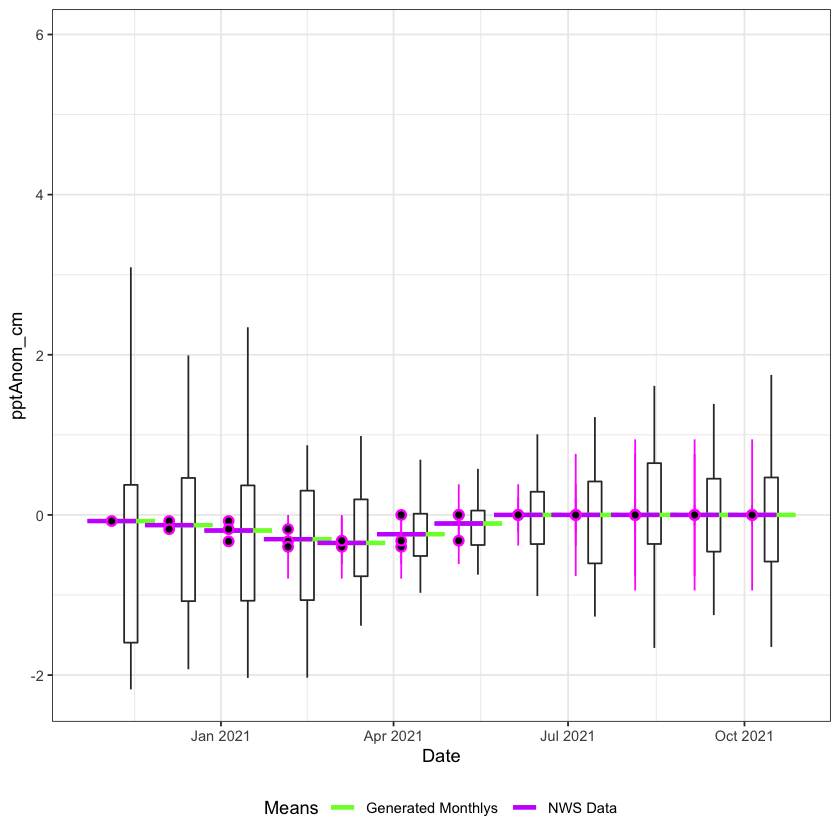

In [27]:
# -------- 1 Monthly multivariate anomalies in green
# -------- 2: Monthly NWS forecasts in magenta
source('../figureCode/testFigs/MONTHLY_NWSvsGeneratedAnoms.R')

# Step 6 - Use weather data to simulate future soil moisture with SOILWAT2 <a id='Step-6'></a>

Next, 900, three-year long SOILWAT2 simulations are run using this data. Each set of anomaly data (n = 30) are applied to each year (y = 30) in the climatological normal record.

Each representation of the future (n X y) is run individually so there is (1) proper spin up and (2) not to confound the accumulation of certain conditions and also to represent the range of possible conditions at the site.

The three years of weather data are:
* 1) Observed (gridMet) data from the previous year
* 2) Observed data to today's date. Predicted data until the end of the year.
* 3) Predicted data to today's date + 1 year. Dummy data for the rest of the year.



# Step 7 - Outputs and Figures <a id='step7'></a>

See the outputs and figures [page](OutputsAndFigures.ipynb) for a full explanation of the calculation and representation of the results. 
